In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, make_scorer, f1_score, precision_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, roc_auc_score

In [90]:
#!/bin/bash
!kaggle datasets download prachi13/customer-analytics

Dataset URL: https://www.kaggle.com/datasets/prachi13/customer-analytics
License(s): other
customer-analytics.zip: Skipping, found more recently modified local copy (use --force to force download)


In [91]:
import os

HOME = os.getcwd()
# 압축 파일의 위치
zipPath = os.path.join(HOME, 'customer-analytics.zip')
# 압축 해제 할 위치
targetPath = os.path.join(HOME, 'data')

In [92]:
from zipfile import ZipFile

with ZipFile(zipPath, 'r') as zip_ref:
    zip_ref.extractall(targetPath)

In [93]:
trainPath = os.path.join(targetPath, 'Train.csv')
df = pd.read_csv(trainPath)
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [95]:
df.describe()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.00000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,5500.00000,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,3175.28214,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,1.00000,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,2750.50000,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,5500.00000,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,8249.50000,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,10999.00000,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


In [96]:
# List of categorical and discrete features
cat_cols = [
    'Warehouse_block', 
    'Mode_of_Shipment', 
    'Product_importance', 
    'Gender', 
    ]

num_cols = [
    'Customer_care_calls', 
    'Customer_rating',
    'Cost_of_the_Product',
    'Prior_purchases',
    'Discount_offered',
    'Weight_in_gms'   
]

In [97]:
from sklearn.model_selection import train_test_split

# 1. stratify 옵션을 써서 정답(Reached.on.Time_Y.N) 비율을 유지하며 8:2로 나눕니다.
# 이 함수는 내부적으로 데이터를 랜덤하게 섞어주기 때문에 sample을 따로 안 써도 됩니다.
part1, part2 = train_test_split(df, 
                                test_size=0.2, 
                                random_state=42, 
                                stratify=df['Reached.on.Time_Y.N'])

# 2. 각각 파일로 저장
part1.to_csv('data/train_df.csv', index=False)
part2.to_csv('data/test_df.csv', index=False)

print("데이터 분할 및 저장 완료!")
print(f"학습용: {part1.shape}, 테스트용: {part2.shape}")

데이터 분할 및 저장 완료!
학습용: (8799, 12), 테스트용: (2200, 12)


In [98]:
train_df = pd.read_csv('data/train_df.csv')
test_df = pd.read_csv('data/test_df.csv')
train_df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,7921,D,Road,4,1,261,2,medium,F,9,4158,0
1,1530,F,Ship,3,3,162,2,low,F,26,1659,1
2,10522,B,Ship,3,2,221,2,medium,M,9,4466,0
3,9559,D,Ship,3,5,157,4,medium,F,2,4640,0
4,969,A,Flight,2,5,272,2,low,M,24,3638,1


In [99]:
print(f"배송 지연 확률: {df['Reached.on.Time_Y.N'].mean() * 100:.2f}%")

배송 지연 확률: 59.67%


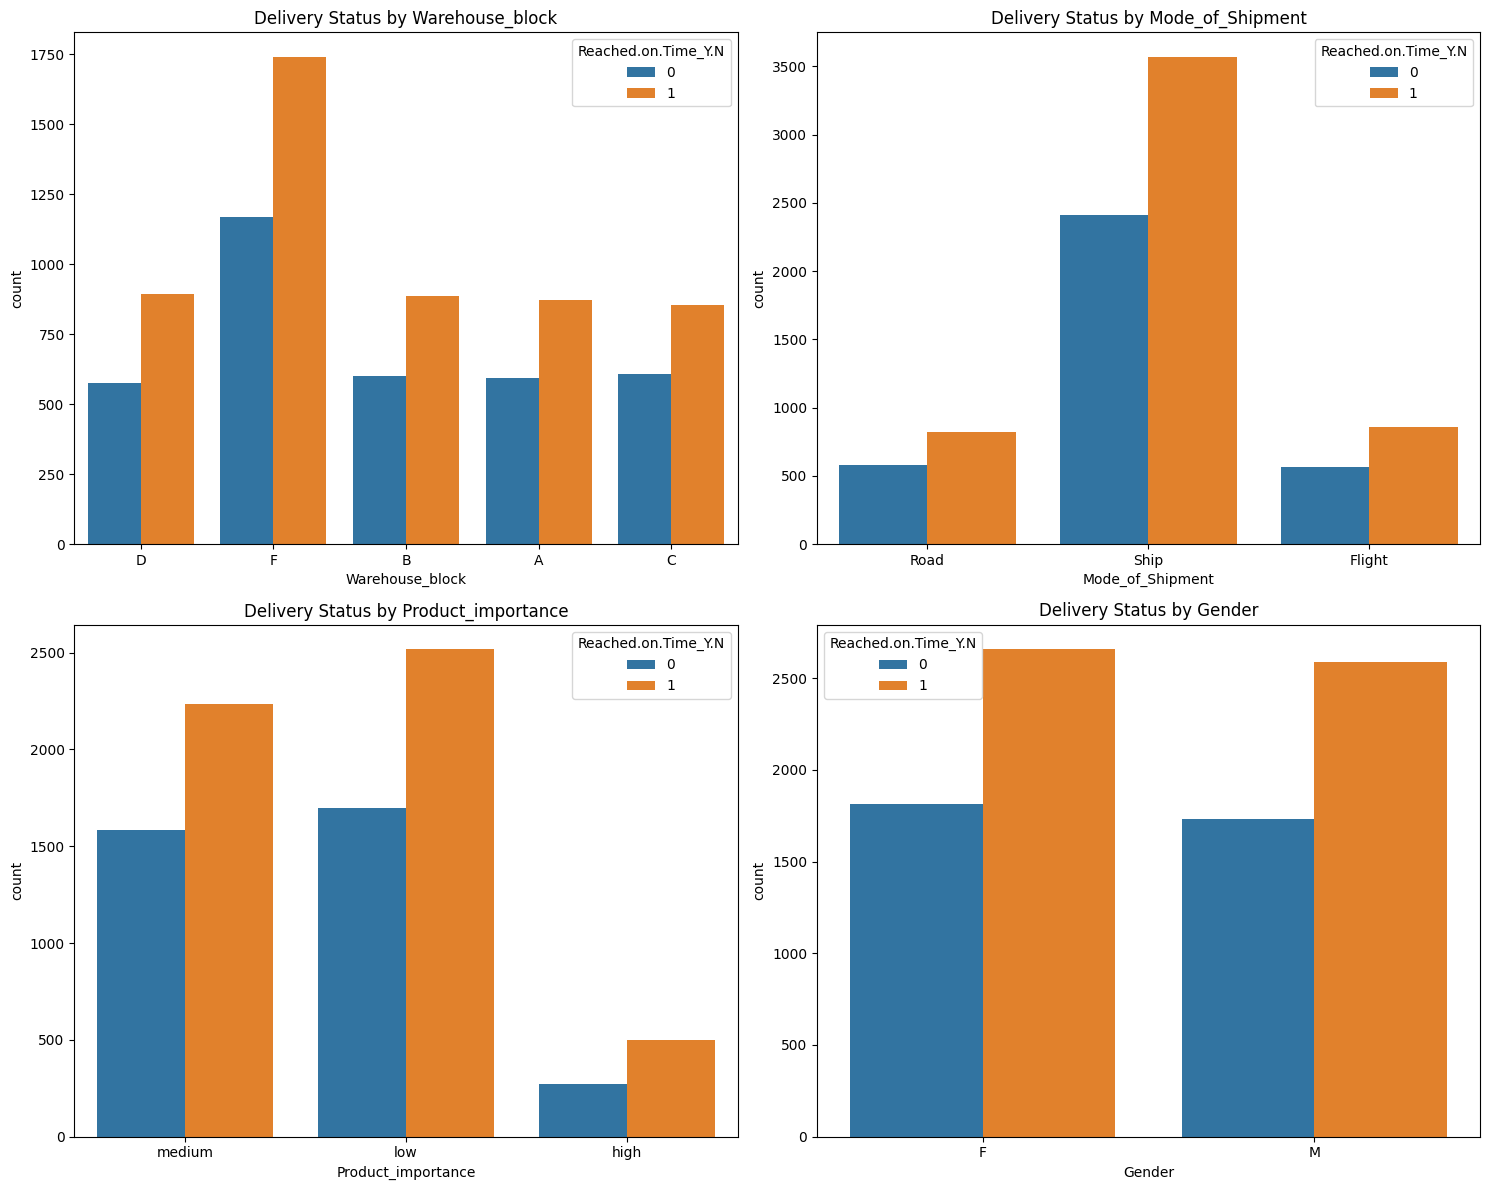

In [100]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(data=train_df, x=col, hue='Reached.on.Time_Y.N', ax=axes[i])
    axes[i].set_title(f'Delivery Status by {col}')

plt.tight_layout()
plt.show()

In [101]:


# Loop through each column and calculate the mean
for col in cat_cols:
    # Calculate the mean, multiply by 100, and format as a percentage string
    result = (train_df.groupby(col)['Reached.on.Time_Y.N'].mean() * 100).map("{:.2f}%".format).to_frame()
    
    print(f"--- Late Rate by {col} ---")
    display(result)

--- Late Rate by Warehouse_block ---


,Reached.on.Time_Y.N
Warehouse_block,
A,59.47%
B,59.65%
C,58.40%
D,60.82%
F,59.83%


--- Late Rate by Mode_of_Shipment ---


,Reached.on.Time_Y.N
Mode_of_Shipment,
Flight,60.42%
Road,58.73%
Ship,59.71%


--- Late Rate by Product_importance ---


,Reached.on.Time_Y.N
Product_importance,
high,64.84%
low,59.75%
medium,58.53%


--- Late Rate by Gender ---


,Reached.on.Time_Y.N
Gender,
F,59.42%
M,59.92%


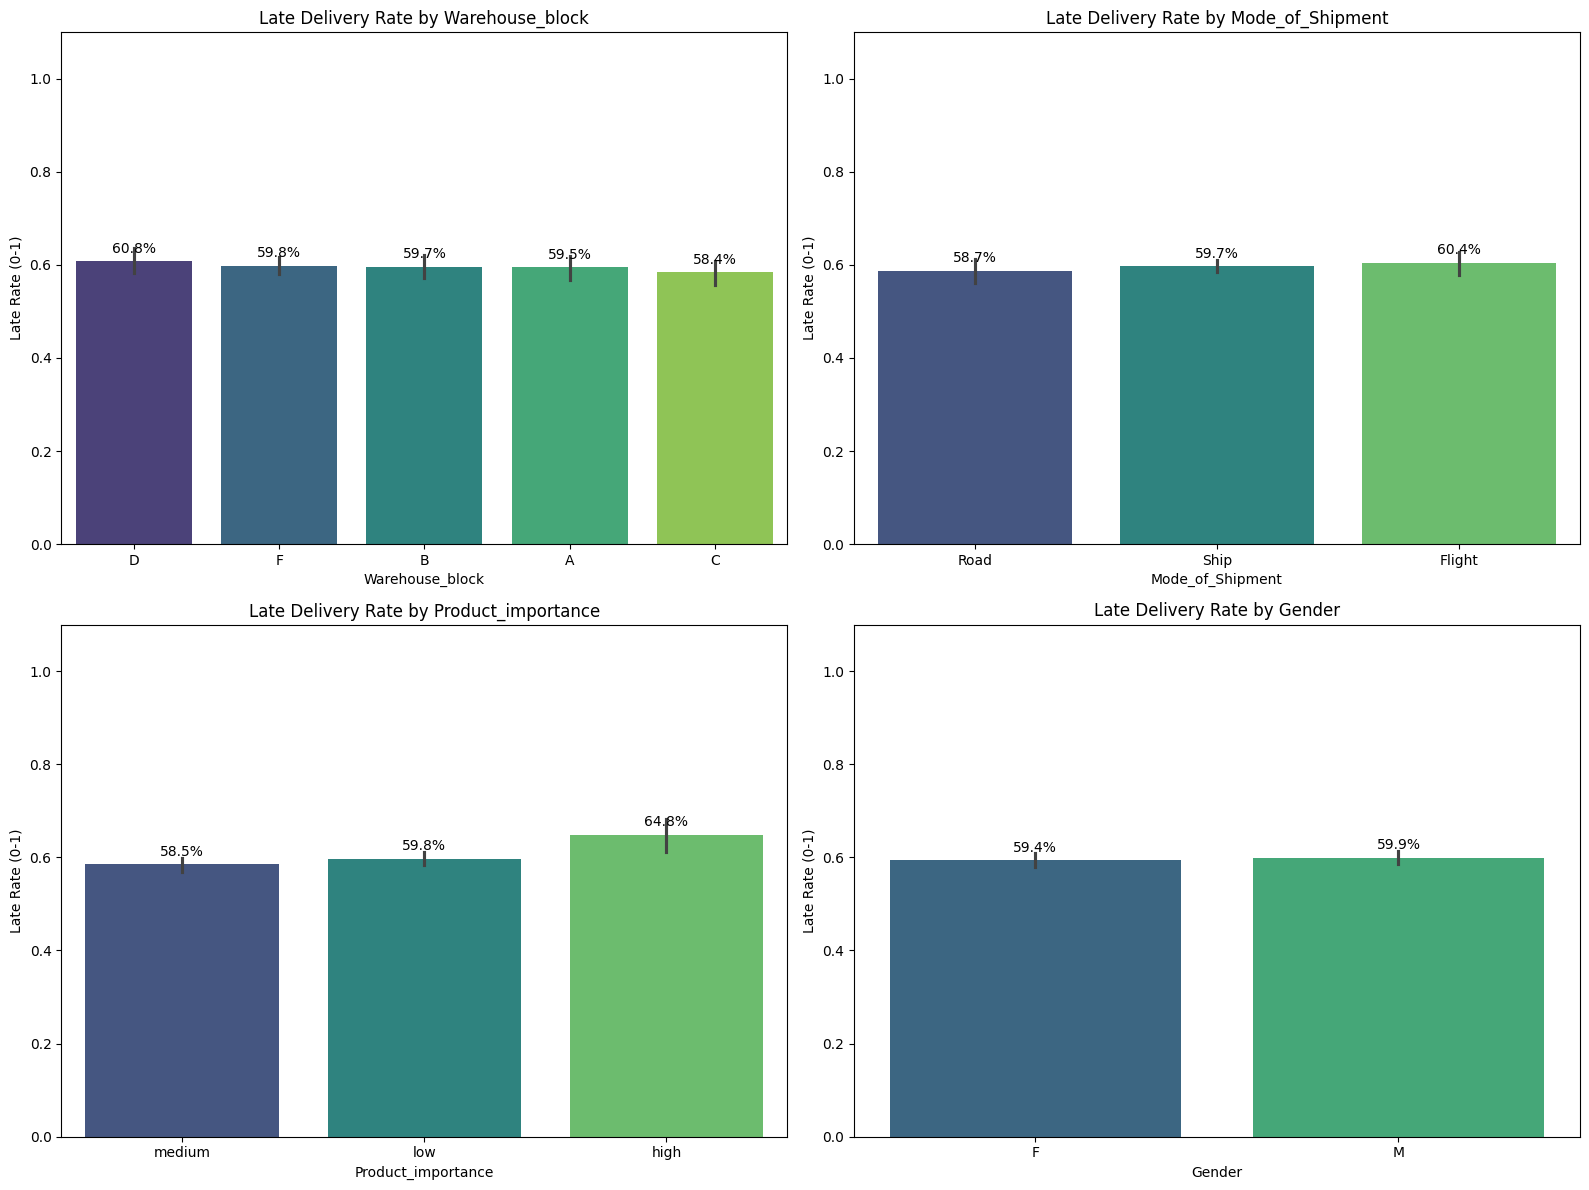

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the figure with a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12)) # Height adjusted for a 2x2 layout
axes = axes.flatten()
for i, col in enumerate(cat_cols):
    sns.barplot(
        data=train_df, 
        x=col, 
        y='Reached.on.Time_Y.N', 
        ax=axes[i], 
        hue=col,            
        palette='viridis', 
        legend=False        
    )
    
    # Adding the percentage labels on top of the bars
    for p in axes[i].patches:
        height = p.get_height()
        axes[i].annotate(f'{height*100:.1f}%', 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', 
                        xytext=(0, 9), 
                        textcoords='offset points')
    axes[i].set_title(f'Late Delivery Rate by {col}')
    axes[i].set_ylabel('Late Rate (0-1)')
    axes[i].set_ylim(0, 1.1)
plt.tight_layout()
plt.show()

In [103]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8799 entries, 0 to 8798
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   8799 non-null   int64 
 1   Warehouse_block      8799 non-null   object
 2   Mode_of_Shipment     8799 non-null   object
 3   Customer_care_calls  8799 non-null   int64 
 4   Customer_rating      8799 non-null   int64 
 5   Cost_of_the_Product  8799 non-null   int64 
 6   Prior_purchases      8799 non-null   int64 
 7   Product_importance   8799 non-null   object
 8   Gender               8799 non-null   object
 9   Discount_offered     8799 non-null   int64 
 10  Weight_in_gms        8799 non-null   int64 
 11  Reached.on.Time_Y.N  8799 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 825.0+ KB


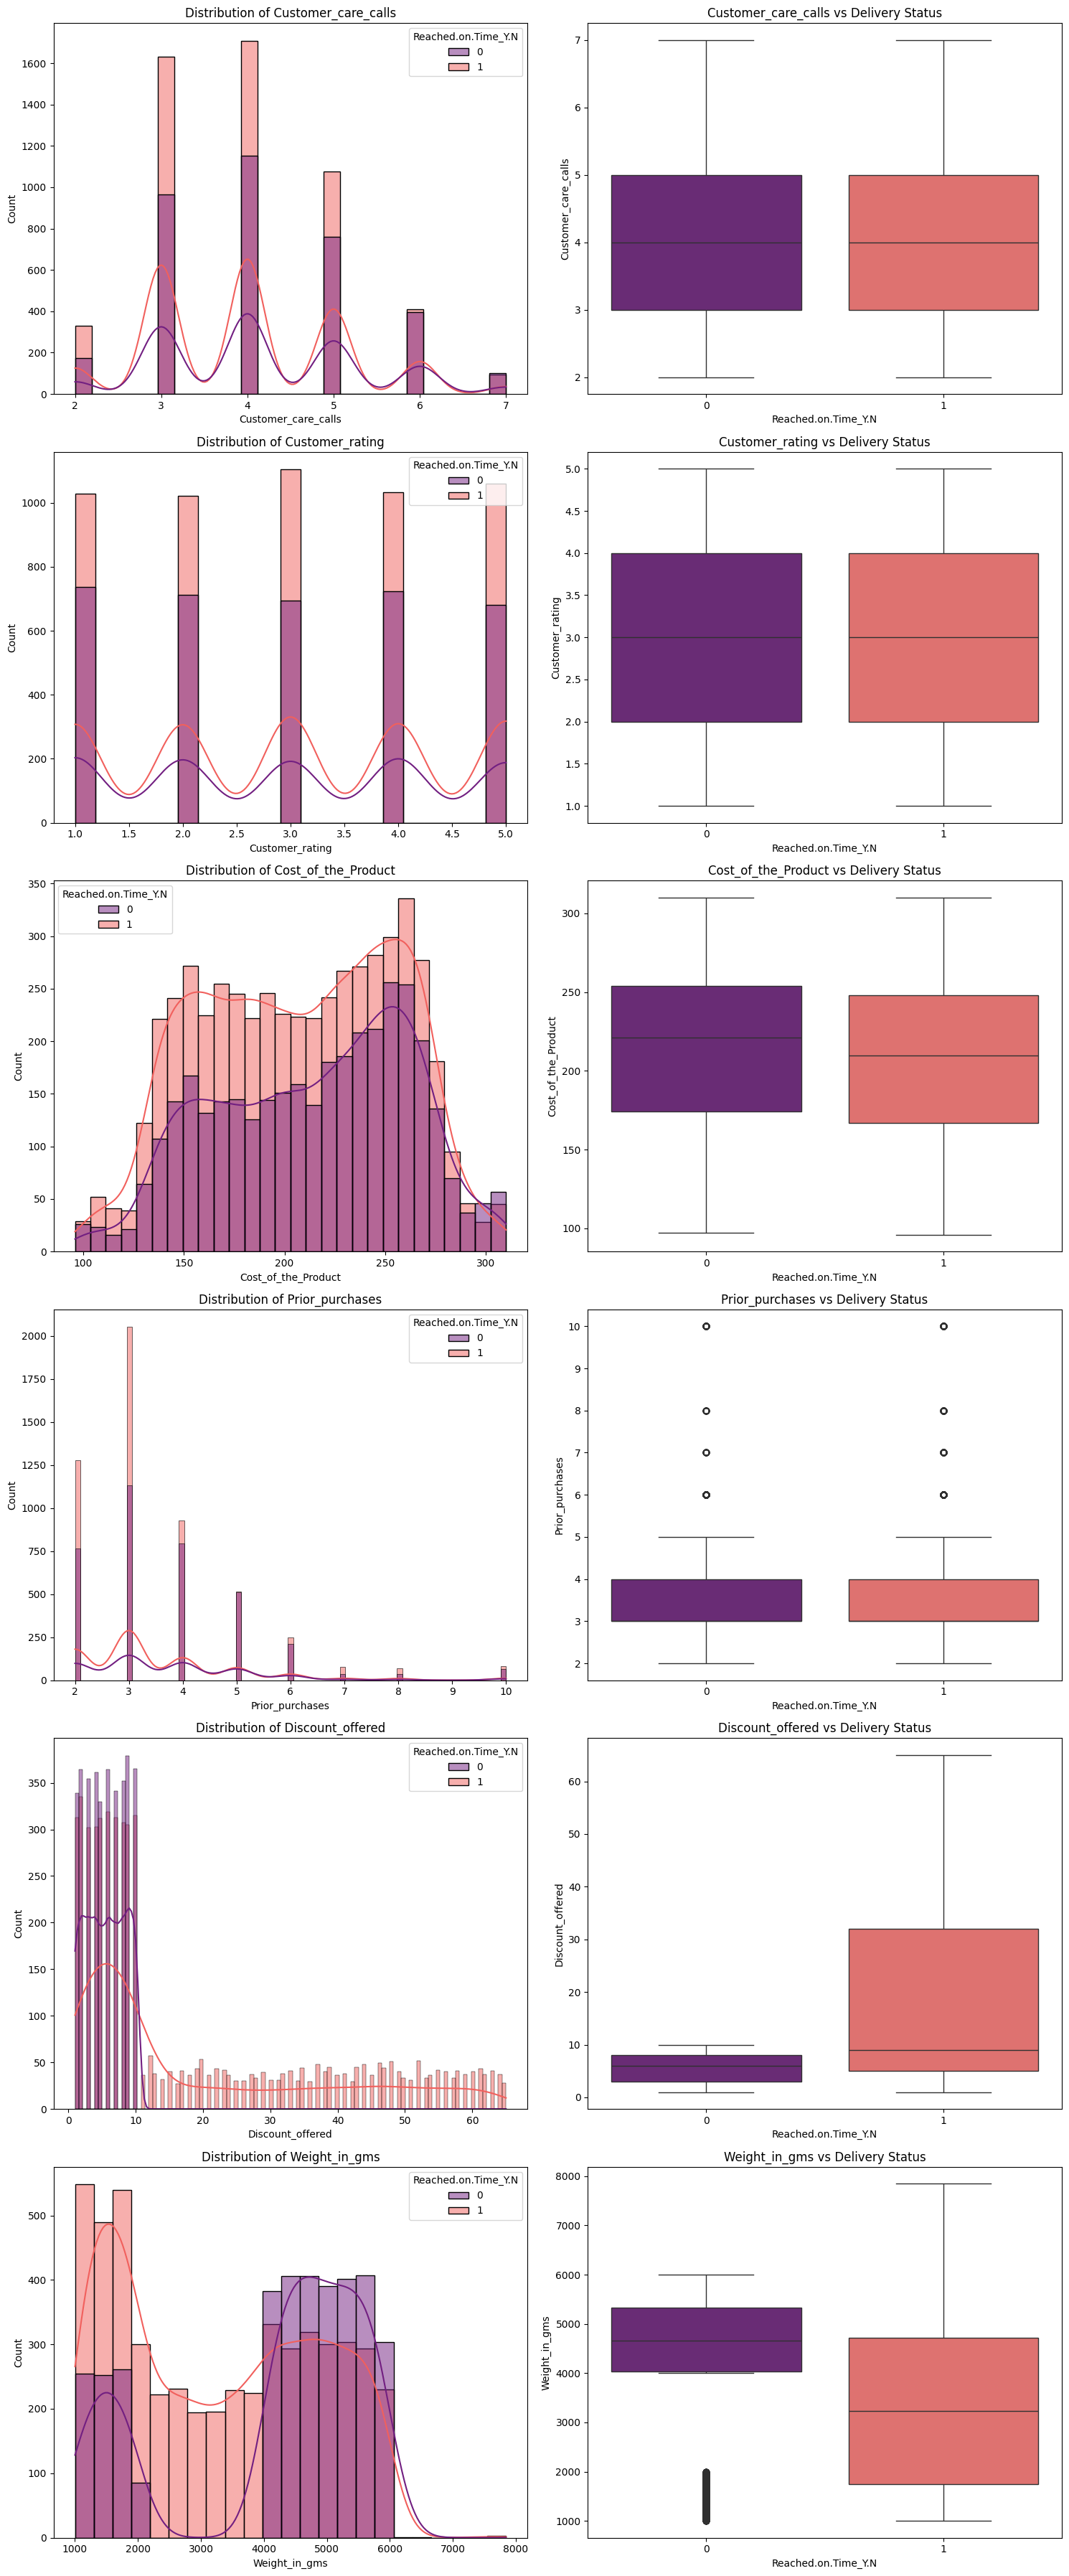

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# num_cols가 현재 4개인 것으로 보입니다. (예: ID나 다른 변수가 포함됨)
# 갯수에 상관없이 작동하도록 행(rows)의 개수를 계산합니다.
n_features = len(num_cols)
rows = n_features
cols = 2

# 그래프 설정
fig, axes = plt.subplots(rows, cols, figsize=(15, 6 * rows))

# 리스트가 1개인 경우 axes가 1차원 배열이 되는 것을 방지하기 위해 2차원으로 정렬
if rows == 1:
    axes = axes.reshape(1, -1)

for i, col in enumerate(num_cols):
    # 1. 히스토그램 & KDE (분포 확인)
    sns.histplot(data=train_df, x=col, hue='Reached.on.Time_Y.N', kde=True, ax=axes[i, 0], palette='magma')
    axes[i, 0].set_title(f'Distribution of {col}')
    
    # 2. 박스 플롯 (이상치 및 중앙값 차이 확인)
    sns.boxplot(data=train_df, x='Reached.on.Time_Y.N', y=col, ax=axes[i, 1], palette='magma', hue='Reached.on.Time_Y.N', legend=False)
    axes[i, 1].set_title(f'{col} vs Delivery Status')

plt.tight_layout()
plt.show()

### Feature Engineering

C:\Users\ysj58\AppData\Local\Temp\ipykernel_8332\526946931.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




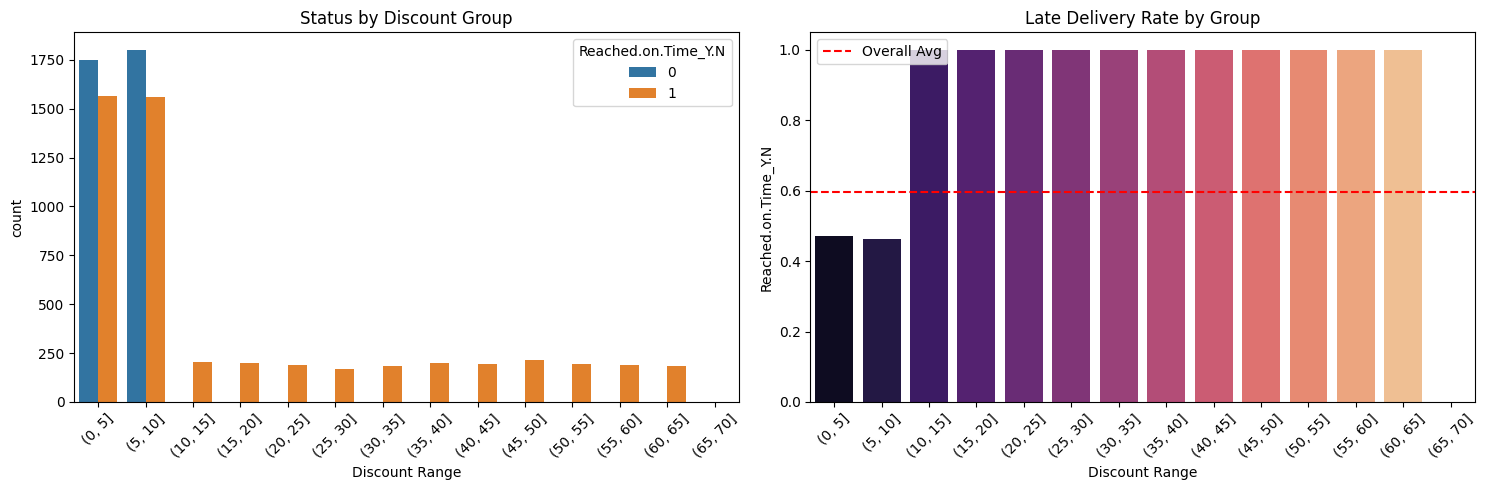

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 데이터 준비: 구간 설정 및 그룹 생성
max_discount = train_df['Discount_offered'].max()
bins = list(range(0, max_discount + 6, 5))
train_df['Discount_Group'] = pd.cut(train_df['Discount_offered'], bins=bins)

# 1행 2열 구조로 시각화 (크기 축소)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. 구간별 빈도수 시각화 (좌측)
sns.countplot(data=train_df, x='Discount_Group', hue='Reached.on.Time_Y.N', ax=axes[0])
axes[0].set_title('Status by Discount Group', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xlabel('Discount Range')

# 2. 구간별 지연율 시각화 (우측)
discount_late_rate = train_df.groupby('Discount_Group', observed=False)['Reached.on.Time_Y.N'].mean().reset_index()
sns.barplot(data=discount_late_rate, x='Discount_Group', y='Reached.on.Time_Y.N', palette='magma', ax=axes[1])
axes[1].set_title('Late Delivery Rate by Group', fontsize=12)
axes[1].axhline(train_df['Reached.on.Time_Y.N'].mean(), color='red', linestyle='--', label='Overall Avg')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_xlabel('Discount Range')
axes[1].legend()

plt.tight_layout()
plt.show()

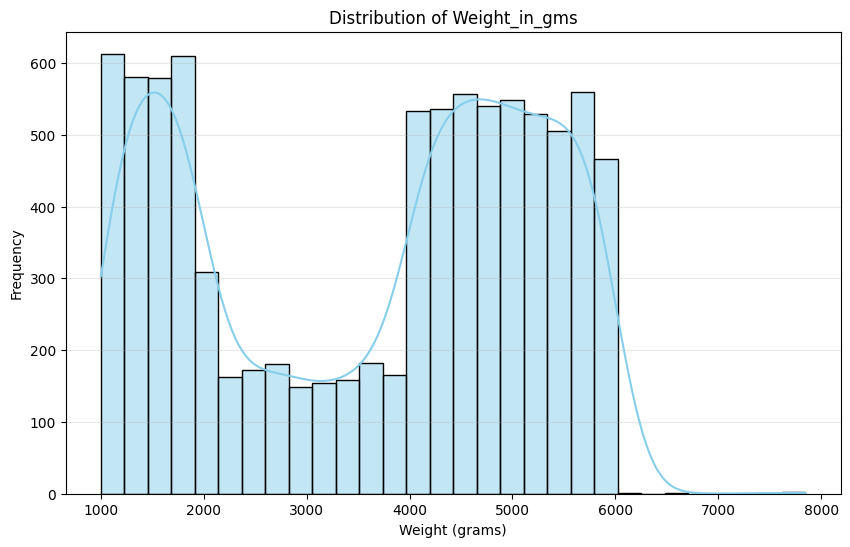

In [106]:
# 'Weight_in_gms' 히스토그램 시각화
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Weight_in_gms'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Weight_in_gms')
plt.xlabel('Weight (grams)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [107]:
train_df['rel_price'] = train_df['Cost_of_the_Product'] / train_df['Weight_in_gms']
display(train_df[['Cost_of_the_Product', 'Weight_in_gms', 'rel_price']].head())

,Cost_of_the_Product,Weight_in_gms,rel_price
0,261,4158,0.062771
1,162,1659,0.097649
2,221,4466,0.049485
3,157,4640,0.033836
4,272,3638,0.074766


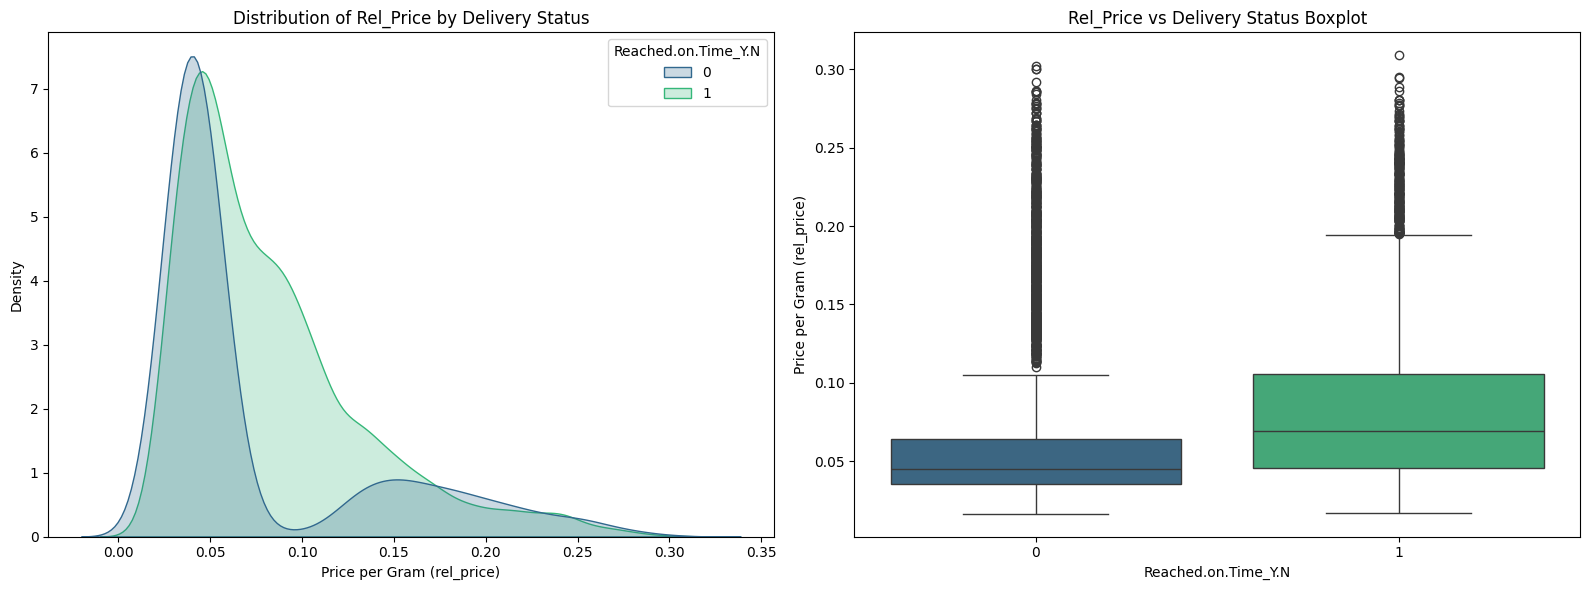

--- Average Rel_Price by Delivery Status ---


,rel_price
Reached.on.Time_Y.N,
0,0.073813
1,0.082960


In [108]:
# 시각화 설정
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. KDE Plot (분포 비교)
sns.kdeplot(data=train_df, x='rel_price', hue='Reached.on.Time_Y.N', fill=True, ax=axes[0], palette='viridis')
axes[0].set_title('Distribution of Rel_Price by Delivery Status')
axes[0].set_xlabel('Price per Gram (rel_price)')

# 2. Box Plot (통계적 차이 확인)
sns.boxplot(data=train_df, x='Reached.on.Time_Y.N', y='rel_price', ax=axes[1], palette='viridis', hue='Reached.on.Time_Y.N', legend=False)
axes[1].set_title('Rel_Price vs Delivery Status Boxplot')
axes[1].set_ylabel('Price per Gram (rel_price)')

plt.tight_layout()
plt.show()

# 추가: 평균값 수치 확인
print("--- Average Rel_Price by Delivery Status ---")
display(train_df.groupby('Reached.on.Time_Y.N')['rel_price'].mean().to_frame())

In [109]:
train_df['rel_price'].describe()

count    8799.000000
mean        0.079270
std         0.055991
min         0.016482
25%         0.039861
50%         0.055030
75%         0.103343
max         0.309073
Name: rel_price, dtype: float64

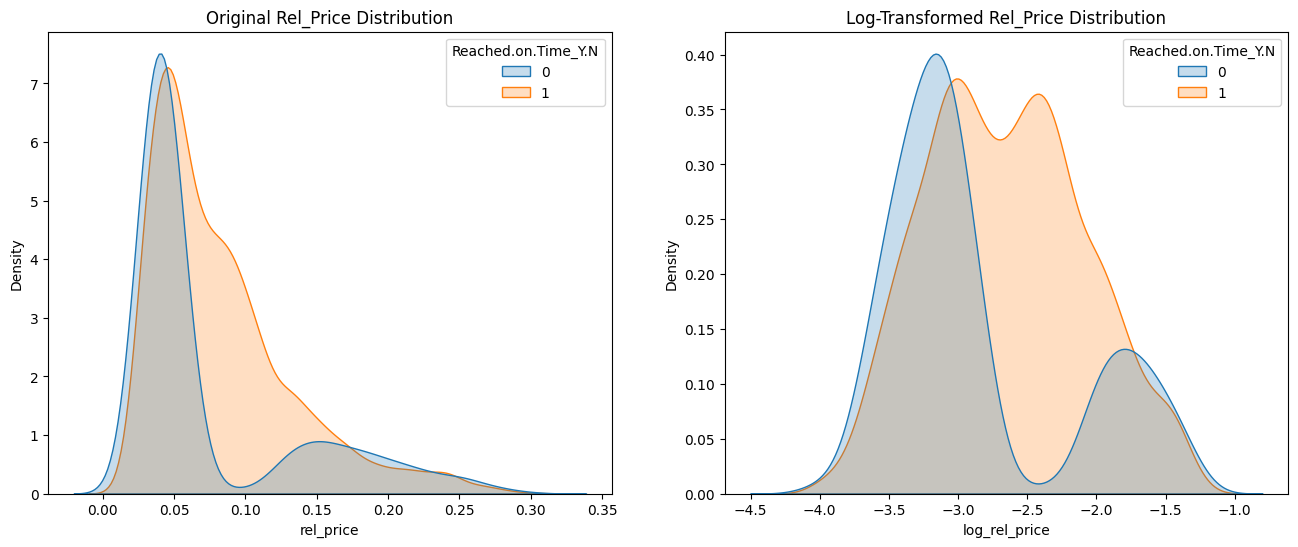

In [110]:
import numpy as np

# 로그 변환 적용 (0이 있을 경우를 대비해 1을 더하는 log1p 사용 가능하지만, 
# 여기서는 양수이므로 np.log 사용)
train_df['log_rel_price'] = np.log(train_df['rel_price'])

# 시각화 비교
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 변환 전
sns.kdeplot(data=train_df, x='rel_price', hue='Reached.on.Time_Y.N', fill=True, ax=axes[0])
axes[0].set_title('Original Rel_Price Distribution')

# 변환 후
sns.kdeplot(data=train_df, x='log_rel_price', hue='Reached.on.Time_Y.N', fill=True, ax=axes[1])
axes[1].set_title('Log-Transformed Rel_Price Distribution')

plt.show()

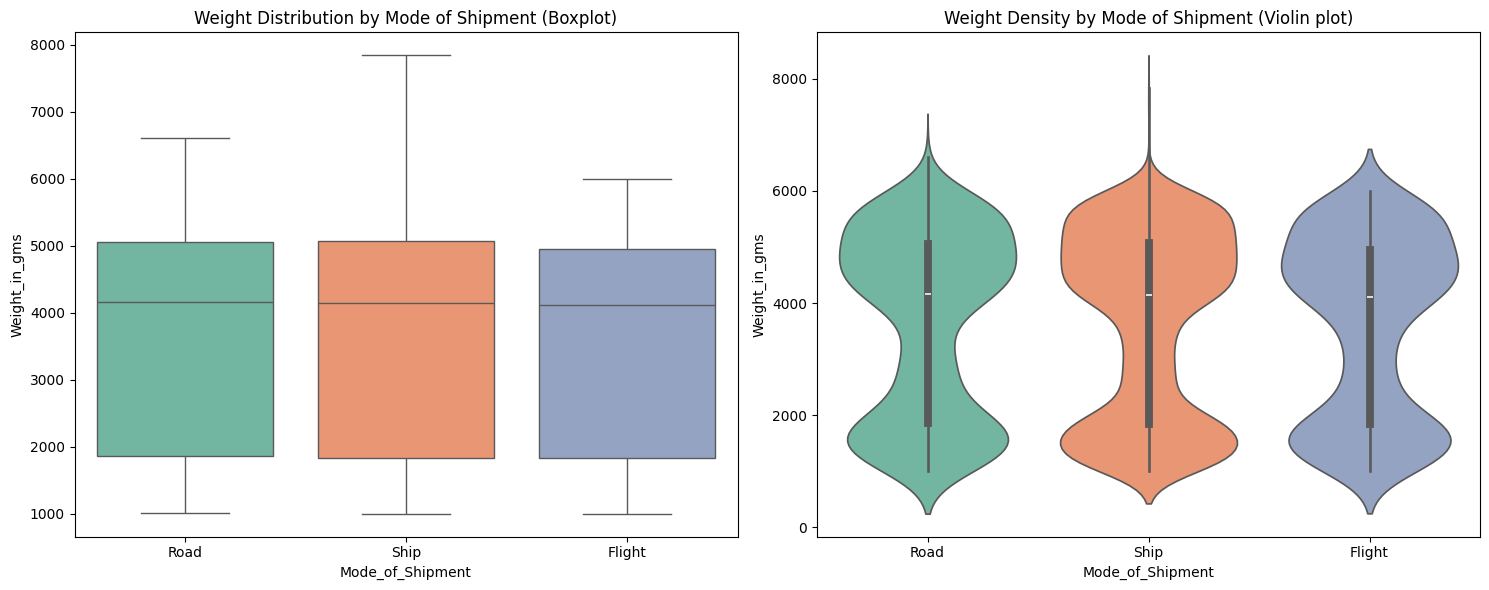

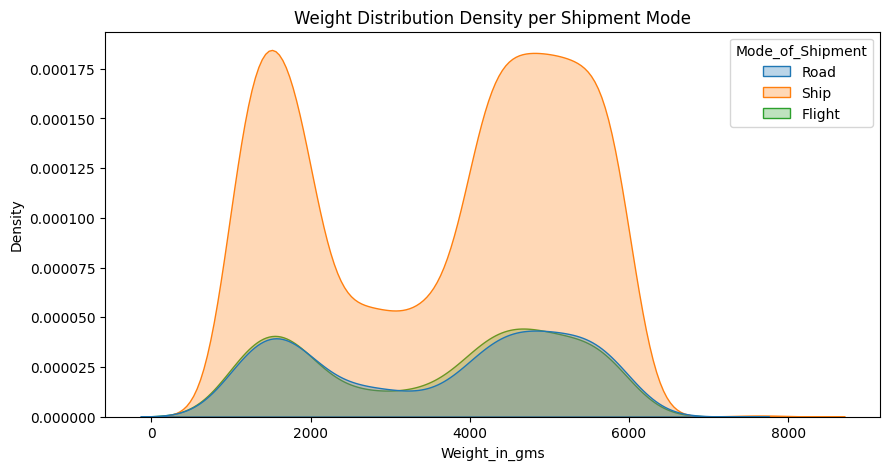

In [111]:
# Mode_of_Shipment와 Weight_in_gms 조합 시각화
plt.figure(figsize=(15, 6))

# 1. 박스플롯: 중앙값, 사분위수 및 이상치 확인
plt.subplot(1, 2, 1)
sns.boxplot(data=train_df, x='Mode_of_Shipment', y='Weight_in_gms', palette='Set2',hue='Mode_of_Shipment', legend=False)
plt.title('Weight Distribution by Mode of Shipment (Boxplot)')

# 2. 바이올린플롯: 전체적인 분포 밀도 확인
plt.subplot(1, 2, 2)
sns.violinplot(data=train_df, x='Mode_of_Shipment', y='Weight_in_gms', palette='Set2',hue='Mode_of_Shipment', legend=False)
plt.title('Weight Density by Mode of Shipment (Violin plot)')

plt.tight_layout()
plt.show()

# 3. 배송 수단별 무게 분포도 (FacetGrid/KDE)
plt.figure(figsize=(10, 5))
sns.kdeplot(data=train_df, x='Weight_in_gms', hue='Mode_of_Shipment', fill=True, alpha=0.3)
plt.title('Weight Distribution Density per Shipment Mode')
plt.show()

In [112]:
train_df['Mode_of_Shipment'].value_counts()

Mode_of_Shipment
Ship      5981
Flight    1420
Road      1398
Name: count, dtype: int64

--- 범주화 결과 (상위 5개) ---
   Weight_in_gms Weight_Category
0           4158           heavy
1           1659           light
2           4466           heavy
3           4640           heavy
4           3638          medium

--- Weight_Category 분포 ---
Weight_Category
heavy     4756
light     2592
medium    1451
Name: count, dtype: int64


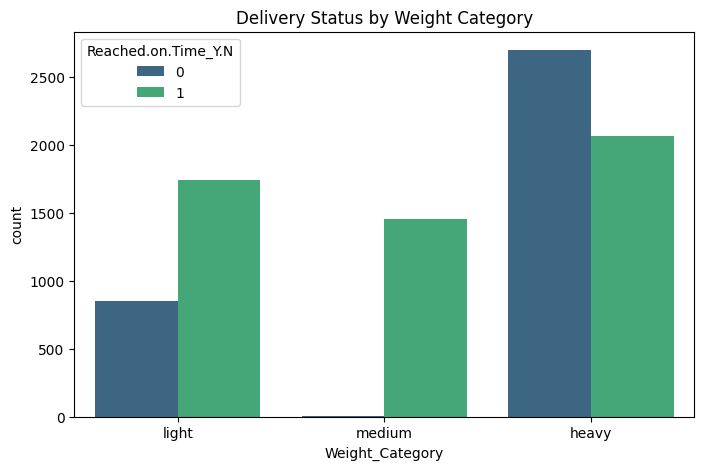

In [113]:
# 'Weight_in_gms' 범주화 (2000, 4000 기준)
# 2000 이하: light, 2000 초과 4000 이하: medium, 4000 초과: heavy
bins = [0, 2000, 4000, float('inf')]
labels = ['light', 'medium', 'heavy']

# train_df와 test_df 모두에 적용
train_df['Weight_Category'] = pd.cut(train_df['Weight_in_gms'], bins=bins, labels=labels)
test_df['Weight_Category'] = pd.cut(test_df['Weight_in_gms'], bins=bins, labels=labels)

# 결과 확인
print("--- 범주화 결과 (상위 5개) ---")
print(train_df[['Weight_in_gms', 'Weight_Category']].head())

# 범주별 분포 확인
print("\n--- Weight_Category 분포 ---")
print(train_df['Weight_Category'].value_counts())

# 시각화로 확인
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x='Weight_Category', hue='Reached.on.Time_Y.N', palette='viridis')
plt.title('Delivery Status by Weight Category')
plt.show()

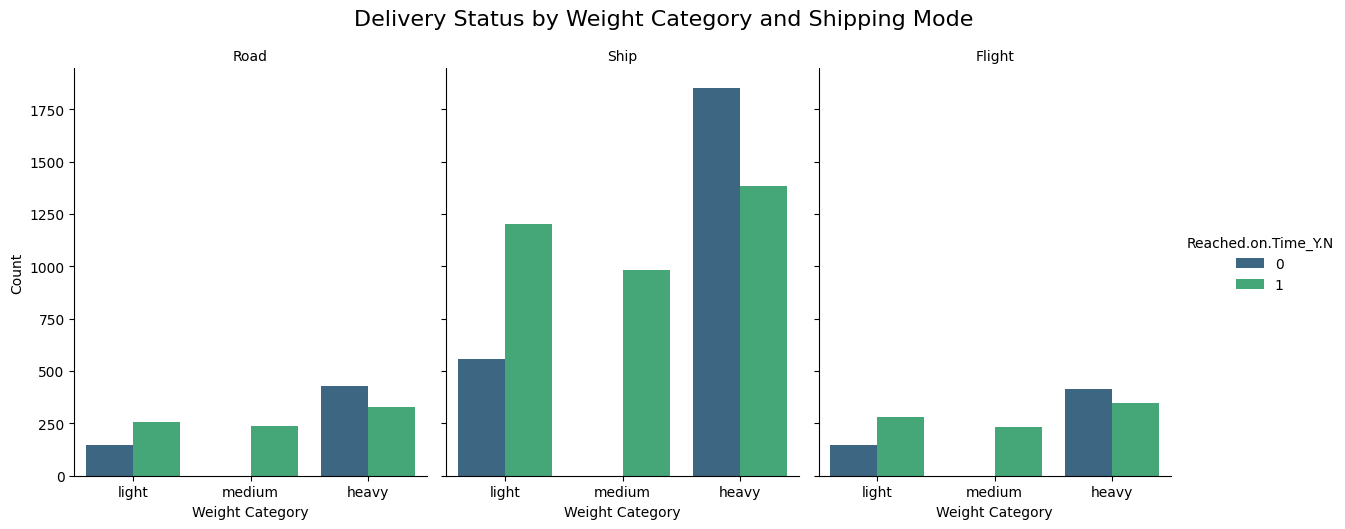

In [114]:
# 배송 수단별 무게 범주에 따른 배송 상태 시각화
g = sns.catplot(
    data=train_df, 
    x='Weight_Category', 
    hue='Reached.on.Time_Y.N', 
    col='Mode_of_Shipment', 
    kind='count',
    palette='viridis',
    height=5, 
    aspect=0.8
)

# 제목 및 라벨 조정
g.set_axis_labels("Weight Category", "Count")
g.set_titles("{col_name}")
g.fig.suptitle('Delivery Status by Weight Category and Shipping Mode', y=1.05, fontsize=16)

plt.show()

In [115]:
# observed=False를 추가하여 경고 해결
summary_table = train_df.groupby(['Mode_of_Shipment', 'Weight_Category'], observed=False)['Reached.on.Time_Y.N'].agg(['count', 'sum']).reset_index()

# 컬럼 명칭 변경
summary_table.columns = ['Mode_of_Shipment', 'Weight_Category', 'Total_Count', 'Late_Count']

# 지연율 계산
summary_table['Late_Rate'] = (summary_table['Late_Count'] / summary_table['Total_Count'] * 100).round(2).astype(str) + '%'

# 피벗 테이블 변환
pivot_summary = summary_table.pivot(index='Mode_of_Shipment', columns='Weight_Category', values='Late_Rate')

print("--- 배송 수단별 & 무게 범주별 지연율 (%) ---")
display(pivot_summary)

print("\n--- 상세 통계 (건수 포함) ---")
display(summary_table)

--- 배송 수단별 & 무게 범주별 지연율 (%) ---


Weight_Category,light,medium,heavy
Mode_of_Shipment,,,
Flight,65.49%,100.0%,45.61%
Road,63.46%,100.0%,43.33%
Ship,68.37%,99.9%,42.77%



--- 상세 통계 (건수 포함) ---


,Mode_of_Shipment,Weight_Category,Total_Count,Late_Count,Late_Rate
0,Flight,light,426,279,65.49%
1,Flight,medium,231,231,100.0%
2,Flight,heavy,763,348,45.61%
3,Road,light,405,257,63.46%
4,Road,medium,236,236,100.0%
5,Road,heavy,757,328,43.33%
6,Ship,light,1761,1204,68.37%
7,Ship,medium,984,983,99.9%
8,Ship,heavy,3236,1384,42.77%


### Feature engineering

In [116]:
train_df = pd.read_csv('data/train_df.csv')
test_df = pd.read_csv('data/test_df.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8799 entries, 0 to 8798
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   8799 non-null   int64 
 1   Warehouse_block      8799 non-null   object
 2   Mode_of_Shipment     8799 non-null   object
 3   Customer_care_calls  8799 non-null   int64 
 4   Customer_rating      8799 non-null   int64 
 5   Cost_of_the_Product  8799 non-null   int64 
 6   Prior_purchases      8799 non-null   int64 
 7   Product_importance   8799 non-null   object
 8   Gender               8799 non-null   object
 9   Discount_offered     8799 non-null   int64 
 10  Weight_in_gms        8799 non-null   int64 
 11  Reached.on.Time_Y.N  8799 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 825.0+ KB


In [117]:
def apply_feature_engineering(df):
    # 1. Discount_Group 생성
    df['Discount_Group'] = (df['Discount_offered'] > 10).astype(int)
    
    # 2. Weight_Category 생성
    bins = [0, 2000, 4000, float('inf')]
    labels = ['light', 'medium', 'heavy']
    # 'Weight_Category' 생성 후 바로 숫자로 인코딩 (Ordinal)
    df['Weight_Category'] = pd.cut(df['Weight_in_gms'], bins=bins, labels=labels)
    # 모델 입력을 위해 숫자로 변환 (light:0, medium:1, heavy:2)
    df['Weight_Category'] = df['Weight_Category'].map({'light': 0, 'medium': 1, 'heavy': 2}).astype(int)
    
    # 3. log_rel_price 생성
    # 무게가 0인 경우를 대비해 아주 작은 값을 더하거나 예외처리 (이 데이터셋은 보통 양수임)
    df['log_rel_price'] = np.log(df['Cost_of_the_Product'] / df['Weight_in_gms'])
    
    #4. Product_importance: Label Encoding (순서가 있으므로 수동 매핑)
    importance_map = {'low': 0, 'medium': 1, 'high': 2}
    df['Product_importance'] = df['Product_importance'].map(importance_map)


    return df

# 각각의 데이터셋에 적용
train_df = apply_feature_engineering(train_df)
test_df = apply_feature_engineering(test_df)


In [118]:
drop_columns = ["ID", "Gender", "Discount_offered", "Weight_in_gms"]
train_df = train_df.drop(drop_columns, axis=1)
test_df = test_df.drop(drop_columns, axis=1)

In [119]:
from sklearn.preprocessing import StandardScaler

# 1. One-Hot Encoding (Warehouse_block, Mode_of_Shipment)
# drop_first=True를 통해 다중공선성을 방지합니다.
train_df = pd.get_dummies(train_df, columns=['Warehouse_block', 'Mode_of_Shipment'])
test_df = pd.get_dummies(test_df, columns=['Warehouse_block', 'Mode_of_Shipment'])

# 2. Scaling 대상 컬럼 선정
# 새로 만든 log_rel_price와 기존 수치형 변수들을 포함합니다.
scale_cols = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 
              'Prior_purchases', 'Discount_Group', 'Weight_Category', 'log_rel_price']

scaler = StandardScaler()

# 중요: fit은 오직 train_df에만 수행합니다!
train_df[scale_cols] = scaler.fit_transform(train_df[scale_cols])

# test와 eval은 transform만 수행하여 데이터 누수를 차단합니다.
test_df[scale_cols] = scaler.transform(test_df[scale_cols])

In [120]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Customer_care_calls      2200 non-null   float64
 1   Customer_rating          2200 non-null   float64
 2   Cost_of_the_Product      2200 non-null   float64
 3   Prior_purchases          2200 non-null   float64
 4   Product_importance       2200 non-null   int64  
 5   Reached.on.Time_Y.N      2200 non-null   int64  
 6   Discount_Group           2200 non-null   float64
 7   Weight_Category          2200 non-null   float64
 8   log_rel_price            2200 non-null   float64
 9   Warehouse_block_A        2200 non-null   bool   
 10  Warehouse_block_B        2200 non-null   bool   
 11  Warehouse_block_C        2200 non-null   bool   
 12  Warehouse_block_D        2200 non-null   bool   
 13  Warehouse_block_F        2200 non-null   bool   
 14  Mode_of_Shipment_Flight 

### 모델 생성

In [121]:
# train_df를 X_train, y_train, X_test, y_test으로 분리

label = 'Reached.on.Time_Y.N'
X = train_df.drop(label, axis=1)
y = train_df[label]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [122]:
X_train.shape

(7039, 16)

Training Logistic Regression...
Training Random Forest...
Training XGBoost...
Training SVM...

=== 모델 성능 비교 ===


,Model,Accuracy,F1-Score,AUC
1,Random Forest,0.673295,0.705882,0.747144
2,XGBoost,0.657386,0.690928,0.747247
0,Logistic Regression,0.664205,0.669278,0.722327
3,SVM,0.678977,0.644430,0.738888


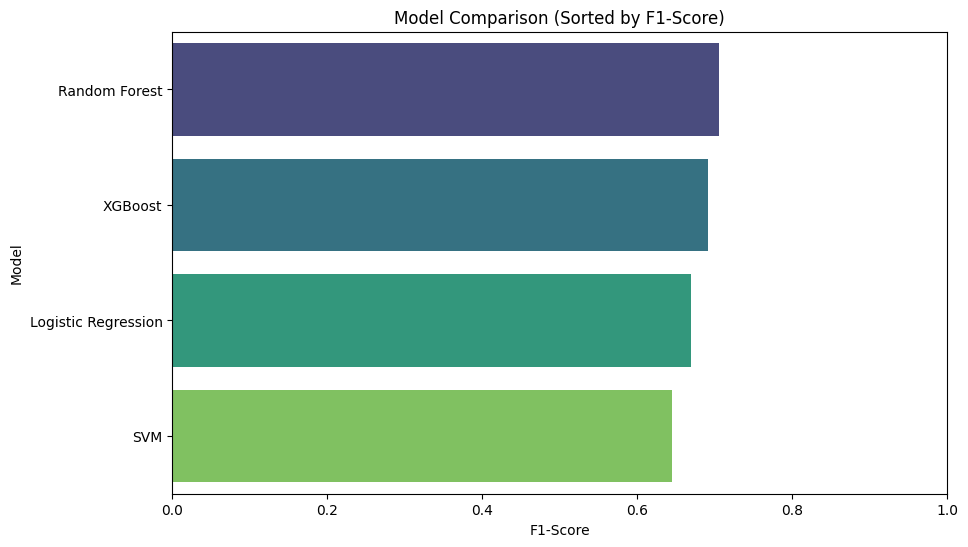

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 모델 라이브러리 임포트
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score


# 테스트할 모델 리스트 정의
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "SVM": SVC(probability=True, random_state=42) # 확률 계산을 위해 probability=True 필요
}

# 모델 학습 및 평가 루프
results = []

for name, model in models.items():
    print(f"Training {name}...")
    
    # 학습
    model.fit(X_train, y_train)
    
    # 예측
    pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)[:, 1] # AUC 계산용 확률값
    
    # 평가 지표 계산
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba)
    
    results.append([name, acc, f1, auc])

# 4. 결과 정리 및 시각화
result_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1-Score", "AUC"])
result_df = result_df.sort_values(by="F1-Score", ascending=False) # F1 점수 기준 정렬

print("\n=== 모델 성능 비교 ===")
display(result_df)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x="F1-Score", y="Model", data=result_df, hue='Model', palette="viridis", legend=False)
plt.title("Model Comparison (Sorted by F1-Score)")
plt.xlim(0, 1)
plt.show()

In [124]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

def objective(trial):
    # 1. Suggest which model to use
    classifier_name = trial.suggest_categorical("classifier", ["Logistic Regression", "Random Forest", "XGBoost", "SVM"])
    
    # 2. Define search spaces for each model
    if classifier_name == "Logistic Regression":
        c = trial.suggest_float("lr_c", 1e-4, 100, log=True)
        model = LogisticRegression(C=c, solver='liblinear', random_state=42)
        
    elif classifier_name == "Random Forest":
        n_estimators = trial.suggest_int("rf_n_estimators", 100, 1000)
        max_depth = trial.suggest_int("rf_max_depth", 3, 15)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        
    elif classifier_name == "XGBoost":
        param = {
            'n_estimators': trial.suggest_int('xgb_n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('xgb_max_depth', 3, 8),
            'learning_rate': trial.suggest_float('xgb_lr', 0.01, 0.2, log=True),
            'subsample': trial.suggest_float('xgb_subsample', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('xgb_min_child', 1, 10),
            'random_state': 42,
            'eval_metric': 'logloss'
        }
        model = XGBClassifier(**param)
        
    else: # SVM
        c = trial.suggest_float("svc_c", 1e-4, 100, log=True)
        gamma = trial.suggest_float("svc_gamma", 1e-4, 1, log=True)
        model = SVC(C=c, gamma=gamma, probability=True, random_state=42)

    # 3. Cross-Validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
    
    return score.mean()

# 4. Run the Optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1) # Increased trials since we have 4 models to test





[I 2026-02-03 11:22:18,734] A new study created in memory with name: no-name-6e043b56-b31a-4e86-9411-f2ecfcf95c41
[I 2026-02-03 11:22:18,843] Trial 3 finished with value: 0.6662519843235024 and parameters: {'classifier': 'Logistic Regression', 'lr_c': 0.300005932019735}. Best is trial 3 with value: 0.6662519843235024.
[I 2026-02-03 11:22:19,190] Trial 0 finished with value: 0.7038695375132492 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 397, 'xgb_max_depth': 6, 'xgb_lr': 0.15953366900984373, 'xgb_subsample': 0.9243202339665106, 'xgb_min_child': 5}. Best is trial 0 with value: 0.7038695375132492.
[I 2026-02-03 11:22:19,491] Trial 2 finished with value: 0.6887872825568426 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 497, 'xgb_max_depth': 4, 'xgb_lr': 0.05330128753647841, 'xgb_subsample': 0.8846801447240205, 'xgb_min_child': 5}. Best is trial 0 with value: 0.7038695375132492.
[I 2026-02-03 11:22:19,963] Trial 4 finished with value: 0.6670655513857165 and 

In [125]:
# 5. 모든 모델의 성능 비교표 작성
df_results = study.trials_dataframe()

# 각 모델(params_classifier)별로 가장 높은 f1-score(value)를 기록한 행만 필터링
comparison_table = df_results.sort_values("value", ascending=False).drop_duplicates("params_classifier")
comparison_table = comparison_table[['params_classifier', 'value']].rename(
    columns={'params_classifier': 'Model', 'value': 'Best_F1'}
)

print("\n### 모델별 성능 비교표 ###")
print(comparison_table.to_string(index=False))


### 모델별 성능 비교표 ###
              Model  Best_F1
                SVM 0.747397
            XGBoost 0.703870
Logistic Regression 0.696840
      Random Forest 0.689708


In [126]:
# 6. 앙상블을 위한 모델별 최적 하이퍼파라미터 추출 함수
def get_best_model_params(model_name):
    # 해당 모델에서 가장 성적이 좋았던 trial 선택
    model_trial = df_results[df_results['params_classifier'] == model_name].sort_values('value', ascending=False).iloc[0]
    # 'params_' 접두사를 제거하고 딕셔너리로 변환
    params = {k.replace('params_', ''): v for k, v in model_trial.items() 
              if k.startswith('params_') and pd.notna(v) and k != 'params_classifier'}
    return params


In [130]:
from sklearn.ensemble import VotingClassifier

# 7. 개별 최적 모델 객체 생성
# (int형 파라미터는 trial 기록 시 float으로 저장될 수 있어 int() 처리가 안전합니다)
lr_p = get_best_model_params("Logistic Regression")
best_lr = LogisticRegression(C=lr_p['lr_c'], solver='liblinear', random_state=42)

rf_p = get_best_model_params("Random Forest")
best_rf = RandomForestClassifier(n_estimators=int(rf_p['rf_n_estimators']), max_depth=int(rf_p['rf_max_depth']), random_state=42)

xgb_p = get_best_model_params("XGBoost")
best_xgb = XGBClassifier(
    n_estimators=int(xgb_p['xgb_n_estimators']), max_depth=int(xgb_p['xgb_max_depth']),
    learning_rate=xgb_p['xgb_lr'], subsample=xgb_p['xgb_subsample'],
    min_child_weight=int(xgb_p['xgb_min_child']), random_state=42, eval_metric='logloss'
)

svc_p = get_best_model_params("SVM")
best_svc = SVC(C=svc_p['svc_c'], gamma=svc_p['svc_gamma'], probability=True, random_state=42)

# 8. Soft Voting Ensemble 모델 구성 및 학습
vote_ensemble = VotingClassifier(
    estimators=[
        ('lr', best_lr),
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('svc', best_svc)
    ],
    voting='soft' # 확률 기반 투표
)

vote_ensemble.fit(X_train, y_train)



,estimators,"[('lr', ...), ('rf', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,np.float64(0....6893835108304)
,fit_intercept,True


In [131]:
# 9. 최종 앙상블 성능 확인
cv_scores = cross_val_score(vote_ensemble, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
print(f"\n[최종] Ensemble 모델 F1 Score: {cv_scores.mean():.4f}")


[최종] Ensemble 모델 F1 Score: 0.6956


In [133]:
from sklearn.ensemble import StackingClassifier

# 1. Stacking에 사용할 개별 모델 리스트 (Base Learners)
# 앞서 정의한 best_lr, best_rf, best_xgb, best_svc를 그대로 사용합니다.
base_models = [
    ('lr', best_lr),
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('svc', best_svc)
]

# 2. 최종 결합 모델 정의 (Meta Learner)
# 개별 모델들의 예측 결과를 받아서 최종 판단을 내리는 모델입니다.
final_model = LogisticRegression()

# 3. Stacking Classifier 구성
stacking_lr = StackingClassifier(
    estimators=base_models,
    final_estimator=final_model,
    cv=5,            # 각 모델의 예측값을 만들 때 사용할 내부 교차 검증 분할 수
    stack_method='predict_proba', # 확률값을 메타 특성으로 사용 (성능에 유리)
    n_jobs=-1
)

# 4. 모델 학습 및 평가
print("Stacking 모델 학습 중...")
stacking_lr.fit(X_train, y_train)

# 최종 성능 확인
stacking_lr_score = cross_val_score(stacking_lr, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()

print(f"\n[최종] Stacking 모델 F1 Score: {stacking_lr_score:.4f}")

Stacking 모델 학습 중...

[최종] Stacking 모델 F1 Score: 0.6871


In [137]:
from sklearn.ensemble import StackingClassifier

# 1. Stacking에 사용할 개별 모델 리스트 (Base Learners)
# 앞서 정의한 best_lr, best_rf, best_xgb, best_svc를 그대로 사용합니다.
base_models = [
    ('lr', best_lr),
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('svc', best_svc)
]

# 2. 최종 결합 모델 정의 (Meta Learner)
# 개별 모델들의 예측 결과를 받아서 최종 판단을 내리는 모델입니다.
final_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# 3. Stacking Classifier 구성
stacking_rf = StackingClassifier(
    estimators=base_models,
    final_estimator=final_model,
    cv=5,            # 각 모델의 예측값을 만들 때 사용할 내부 교차 검증 분할 수
    stack_method='predict_proba', # 확률값을 메타 특성으로 사용 (성능에 유리)
    n_jobs=-1
)

# 4. 모델 학습 및 평가
print("Stacking 모델 학습 중...")
stacking_rf.fit(X_train, y_train)

# 최종 성능 확인
stacking_rf_score = cross_val_score(stacking_rf, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()

print(f"\n[최종] Stacking 모델 F1 Score: {stacking_rf_score:.4f}")

Stacking 모델 학습 중...

[최종] Stacking 모델 F1 Score: 0.6513


In [140]:
from sklearn.model_selection import cross_validate
import pandas as pd

# 1. 비교할 모든 모델 리스트업
# 위에서 생성한 개별 최적 모델들과 앙상블 모델들을 모읍니다.
all_models = [
    ('Logistic Regression', best_lr),
    ('Random Forest', best_rf),
    ('XGBoost', best_xgb),
    ('SVM', best_svc),
    ('Ensemble_Voting', ensemble_model),
    ('Ensemble_Stacking_LR', stacking_lr),
    ('Ensemble_Stacking_RF', stacking_rf)
]

# 2. 성능 지표 계산 (F1 & Accuracy)
results = []

print("전체 모델 성능 평가 중...")
for name, model in all_models:
    # f1과 accuracy를 동시에 교차 검증
    cv_results = cross_validate(
        model, X_train, y_train, 
        cv=5, 
        scoring=['f1', 'accuracy'], 
        n_jobs=-1
    )
    
    results.append({
        'Model': name,
        'F1_Score': cv_results['test_f1'].mean(),
        'Accuracy': cv_results['test_accuracy'].mean()
    })

# 3. 결과 비교표 출력
df_final_comparison = pd.DataFrame(results).sort_values(by='F1_Score', ascending=False)

print("\n" + "="*50)
print(" [ 최종 모델 성능 비교 결과 ]")
print("="*50)
print(df_final_comparison.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
print("="*50)

전체 모델 성능 평가 중...

 [ 최종 모델 성능 비교 결과 ]
               Model  F1_Score  Accuracy
                 SVM    0.7474    0.5967
             XGBoost    0.6985    0.6536
     Ensemble_Voting    0.6956    0.6607
       Random Forest    0.6950    0.6691
 Logistic Regression    0.6948    0.6629
Ensemble_Stacking_LR    0.6871    0.6690
Ensemble_Stacking_RF    0.6513    0.6870


In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.exceptions import NotFittedError

# 1. 테스트 데이터 준비 
X_test = test_df.drop(columns=[label])
y_test = test_df[label]

# 2. 데이터 수집
final_report_data = []

print("최종 성능 검증 진행 중...")
for name, model in all_models:
    try:
        # 우선 예측을 시도해봅니다.
        y_pred = model.predict(X_test)
    except NotFittedError:
        # 만약 학습이 안 되어 있다면 여기서 학습을 시킵니다.
        print(f"  - {name} 모델 학습 중...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # 지표 계산
    t_f1 = f1_score(y_test, y_pred)
    t_acc = accuracy_score(y_test, y_pred)
    
    final_report_data.append({
        'Model': name,
        'Test_F1': t_f1,
        'Test_Accuracy': t_acc
    })


최종 성능 검증 진행 중...
  - Logistic Regression 모델 학습 중...
  - Random Forest 모델 학습 중...
  - XGBoost 모델 학습 중...
  - SVM 모델 학습 중...


In [149]:
# 3. 결과 데이터프레임 생성 및 정렬
df_final = pd.DataFrame(final_report_data).sort_values(by='Test_Accuracy', ascending=False)
df_final

,Model,Test_F1,Test_Accuracy
1,Random Forest,0.700680,0.680000
6,Ensemble_Stacking_RF,0.635524,0.677273
5,Ensemble_Stacking_LR,0.684677,0.676364
0,Logistic Regression,0.695142,0.669091
4,Ensemble_Voting,0.695400,0.665909
2,XGBoost,0.689765,0.645909
3,SVM,0.747509,0.596818


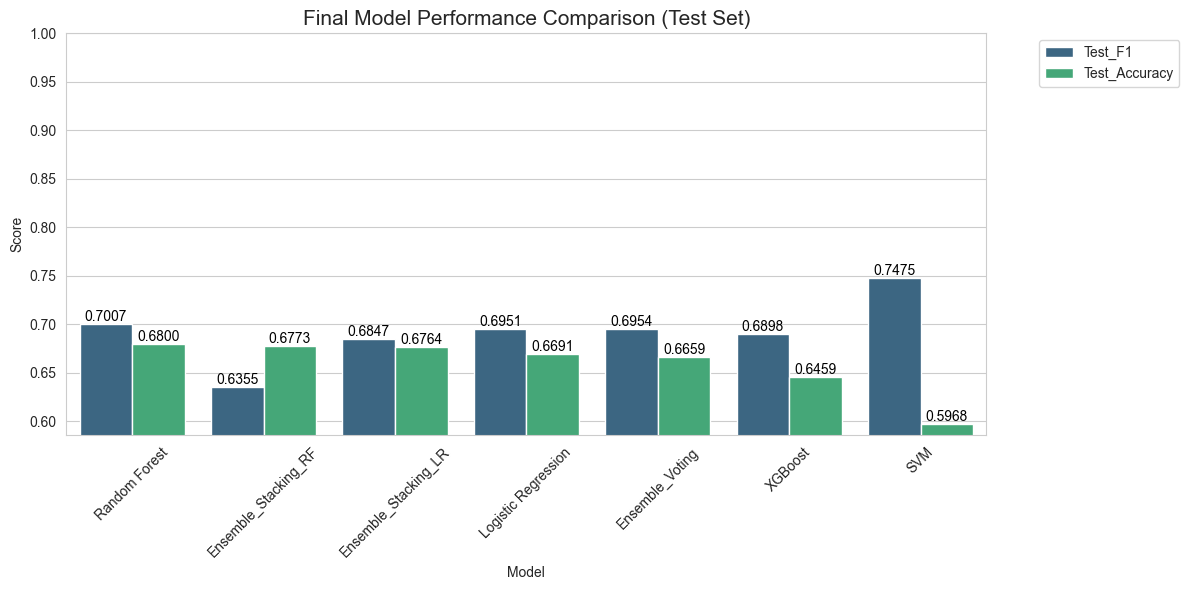

In [150]:
# 4. [보고서용] 시각화 (Bar Chart)
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
melted_df = df_final.melt(id_vars='Model', var_name='Metric', value_name='Score')
ax = sns.barplot(data=melted_df, x='Model', y='Score', hue='Metric', palette='viridis')

plt.title('Final Model Performance Comparison (Test Set)', fontsize=15)
plt.ylim(df_final['Test_F1'].min() - 0.05, 1.0) # 차이를 명확히 보기 위해 하한선 조절
plt.xticks(rotation=45)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [151]:
# 5. 최종 비교표 출력
print("\n" + "="*60)
print(" [ 최종 보고서용 성능 비교표 ]")
print("="*60)
print(df_final.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
print("="*60)


 [ 최종 보고서용 성능 비교표 ]
               Model  Test_F1  Test_Accuracy
       Random Forest   0.7007         0.6800
Ensemble_Stacking_RF   0.6355         0.6773
Ensemble_Stacking_LR   0.6847         0.6764
 Logistic Regression   0.6951         0.6691
     Ensemble_Voting   0.6954         0.6659
             XGBoost   0.6898         0.6459
                 SVM   0.7475         0.5968


In [152]:
# 6. 최우수 모델 상세 리포트 (가장 성적이 좋은 모델)
best_model_name = df_final.iloc[0]['Model']
best_model_obj = dict(all_models)[best_model_name]
print(f"\n🏆 최우수 모델: {best_model_name}")
print(classification_report(y_test, best_model_obj.predict(X_test)))


🏆 최우수 모델: Random Forest
              precision    recall  f1-score   support

           0       0.58      0.76      0.66       887
           1       0.79      0.63      0.70      1313

    accuracy                           0.68      2200
   macro avg       0.69      0.69      0.68      2200
weighted avg       0.71      0.68      0.68      2200

